In [63]:
import os, glob, pickle
import pandas as pd
import re
import time
import itpScraper
from bs4 import BeautifulSoup
import numpy as np
import datetime
import sys
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>'''
    )

In [3]:
def extract_filename_time(x):
    pattern = 'UserSessionDicts_Temp_(\d\d-\d\d-\d\d)_(.*?).pickle'
    return pd.to_datetime("_".join(re.findall(pattern, x)[0]), format="%m-%d-%y_%H%M%p")

In [4]:
fresh_scrape = False

In [5]:
prior_scrape_folders = [f for f in glob.glob("Scrape*") if re.match("Scrape(\d+)", f)]
prior_scrape_folders = sorted(prior_scrape_folders, key=lambda f: int(re.findall("Scrape(\d+)", f)[0]))
most_recent_scrape = prior_scrape_folders[-1]
print("Most recent scrape: {}".format(most_recent_scrape))

# os.chdir(most_recent_scrape)
os.chdir('/Users/matthewmitchell/Documents/ITP_Camp/PeopleCluster/Scrape2')

#Navigate to Last Scrape
temp_dicts = glob.glob("UserSessionDicts_Temp*")
# pattern = 'UserSessionDicts_Temp_(\d\d-\d\d-\d\d)_(.*?).pickle'
temp_dicts = sorted(temp_dicts, key=extract_filename_time)
print("Last 5 files scraped:\n", temp_dicts[-5:])

# filename = temp_dicts[-1]
# with open(filename, 'rb') as f:
#     user_dicts_prev = pickle.load(f)

user_dict = {}
for filename in temp_dicts:
    with open(filename, 'rb') as f:
        temp = pickle.load(f)
    user_dict = {**user_dict, **temp}
#     sys.stdout.write("\r{}".format(len(user_dict)))
#     time.sleep(.25)
# print("Total Users Scraped Thus Far: {}".format(len(user_dicts_prev)))
# last_user_scraped = list(user_dicts_prev.keys())[-1]
# print("Last User Scraped: {}".format(last_user_scraped))

all_ids = sorted(list(set([s['id'] for sessions in user_dict.values() for s in sessions])))


Most recent scrape: Scrape3
Last 5 files scraped:
 ['UserSessionDicts_Temp_06-16-23_1600PM.pickle', 'UserSessionDicts_Temp_06-16-23_1602PM.pickle', 'UserSessionDicts_Temp_06-16-23_1609PM.pickle', 'UserSessionDicts_Temp_06-16-23_1614PM.pickle', 'UserSessionDicts_Temp_06-16-23_1618PM.pickle']


## Original Parsing of Session Info - Binary Attendance Grid

In [6]:
sessions_master_dict = {}
user_arrays = {}
user_corpuses = []
errors = []
users_w_errors = []
for ud in [user_dict]:
    user_names = list(ud.keys())
    for user in user_names:
        user_corpus = []
        try:
            user_sessions = ud[user]
            #Create User Array
            u_s_ids = sorted([s['id'] for s in user_sessions])
            user_array = np.isin(all_ids, u_s_ids).astype(int)
            user_arrays[user] = user_array
            for s in user_sessions:
                #Add Tags to User Corpus
                [user_corpus.append(t) for t in s['tags']]
                #If Session Not Previously Seen Cache in Master Session Dict
                if s['id'] not in sessions_master_dict.keys():
                    sessions_master_dict[s['id']] = s
            user_corpus = " ".join(user_corpus)
            user_corpuses.append((user, user_corpus))
        except Exception as e:
            print("Hit Error: ", e)
            errors.append(e)
            users_w_errors.append(user)
print(len(sessions_master_dict.keys()))
#Create DF From Sparse User Arrays
df = pd.DataFrame.from_dict(user_arrays, orient='index')
df.columns = all_ids
print(df.shape)
df.head()

264
(217, 264)


,1,8,9,10,11,12,13,14,15,16,...,314,315,316,317,319,320,321,322,323,324
Abby Schmiedt,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Ada Varriale (she/her),0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
Adeline Setiawan,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Aki,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alan Wong,0,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Euclidean Distance and User Correlation Heatmap

In [7]:
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(df, df)

In [8]:
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import metrics
from sklearn.cluster import KMeans

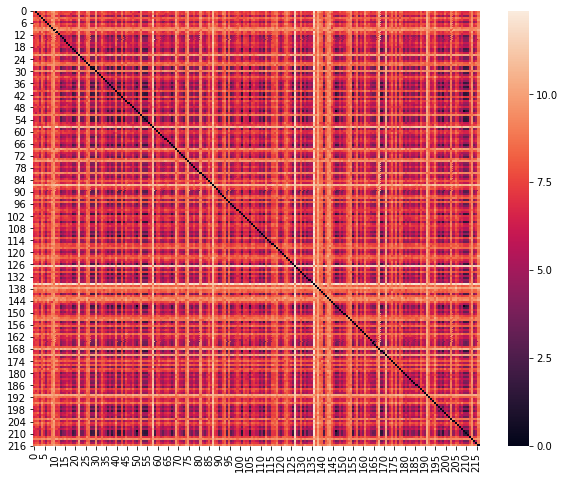

In [9]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(dist)

## KMeans Clustering - What is an Ideal Number of User Clusters....?

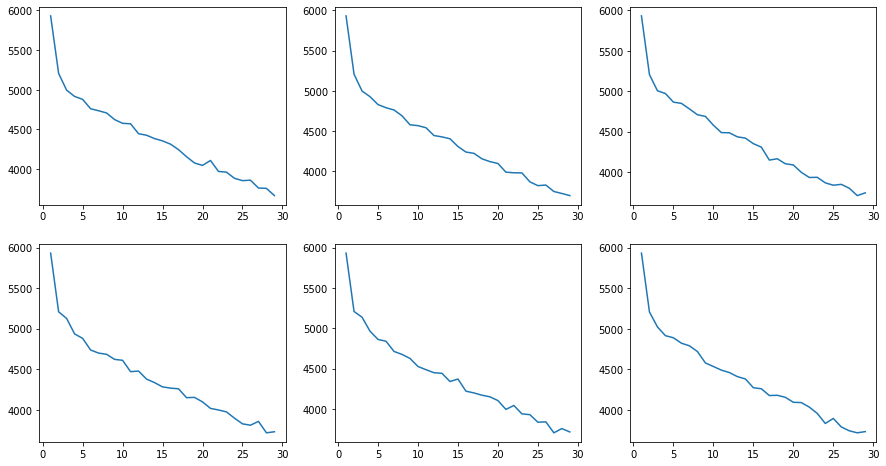

In [10]:
#This has a random seed - you can rerun with slightly different results

ncols = 2
fig, axs = plt.subplots(ncols,3, figsize=(15,8))

for n in range(6):
    cluster_inertias = []
    cluster_sizes = []


    ax = axs[n%ncols][n//ncols]
    for i in range(1,30):
        kmeans = KMeans(
            n_clusters=i,
            max_iter=100,
            n_init=1,
        ).fit(df)

        cluster_inertias.append(kmeans.inertia_)
        cluster_sizes.append(i)
    ax.plot(cluster_sizes, cluster_inertias)

In [11]:
kmeans = KMeans(n_clusters=15,
                max_iter=100,
                n_init=1,
                )
clusters = kmeans.fit_predict(df)
# print(clusters.shape)
# print(Counter(clusters))

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## PCA Viz

Explained variance:  [0.17364943 0.03694396 0.03168577]


Text(0.5, 1.0, 'Users Based on Binary Attendance')

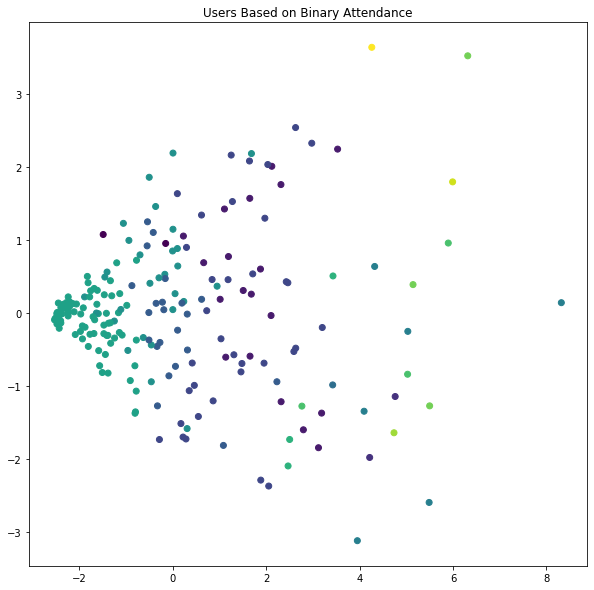

In [13]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df)

print("Explained variance: ",pca.explained_variance_ratio_)
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters)
plt.title("Users Based on Binary Attendance")

In [14]:
from mpl_toolkits.mplot3d import Axes3D

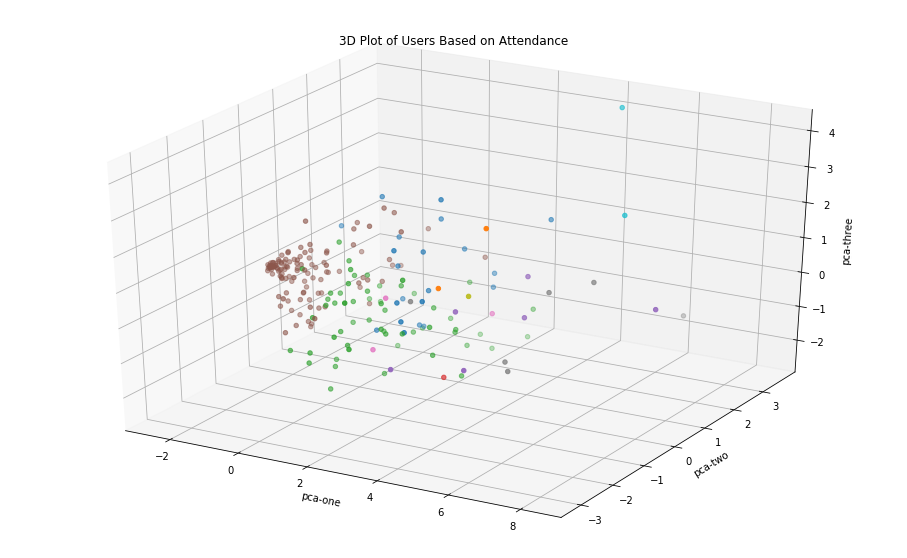

In [15]:
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=clusters, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
# plt.show()
plt.title("3D Plot of Users Based on Attendance");

### TSNE VIZ

In [16]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 217 samples in 0.000s...
[t-SNE] Computed neighbors for 217 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 217 / 217
[t-SNE] Mean sigma: 1.663524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.163078
[t-SNE] KL divergence after 300 iterations: 1.287535


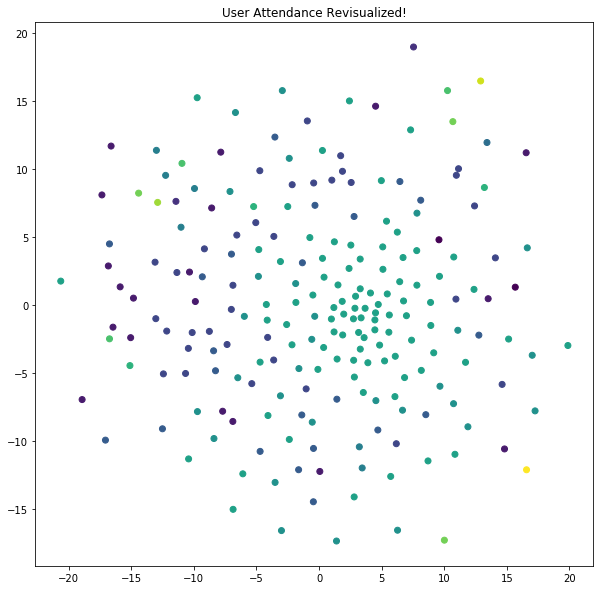

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters)
plt.title("User Attendance Revisualized!");

### Adding User Labels

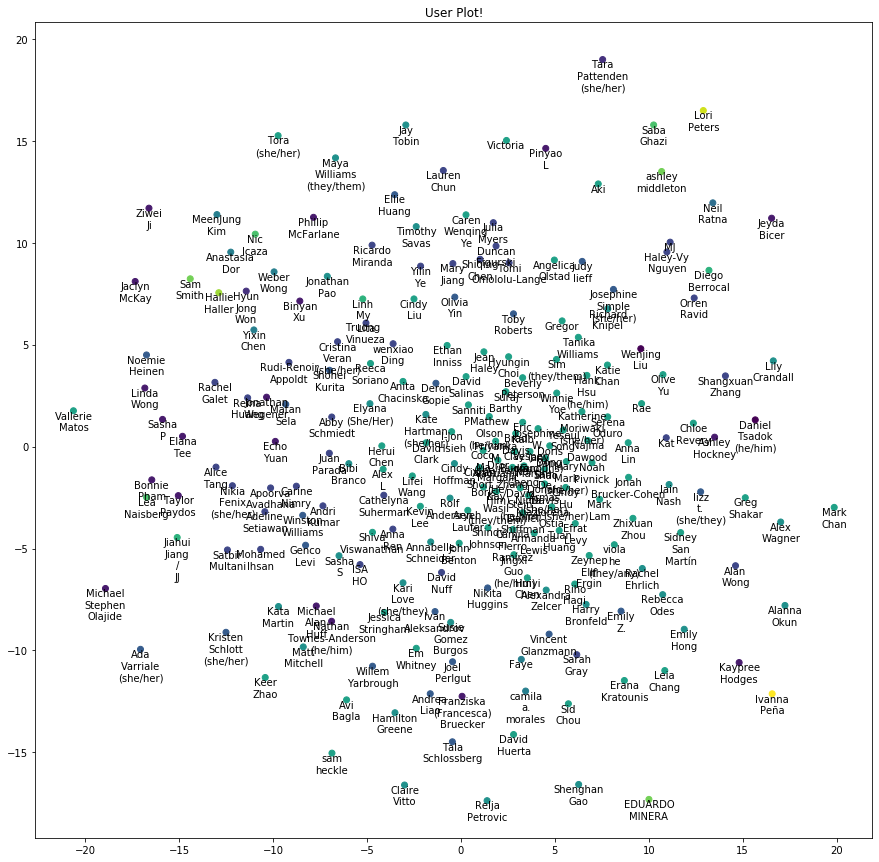

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters)

# add labels to all points
for (xi, yi, name) in zip(tsne_results[:,0], tsne_results[:,1], df.index):
    plt.text(xi, yi, "\n".join(name.split()), va='top', ha='center')

# filename = "ITP_TSNE_Campers_Clustering_{}.png".format(time_now)    
# plt.savefig(filename)
plt.title("User Plot!");

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 217 samples in 0.002s...
[t-SNE] Computed neighbors for 217 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 217 / 217
[t-SNE] Mean sigma: 1.663524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 154.771393
[t-SNE] KL divergence after 300 iterations: 4.088607


Text(0.5, 0.92, '3D User Plot!')

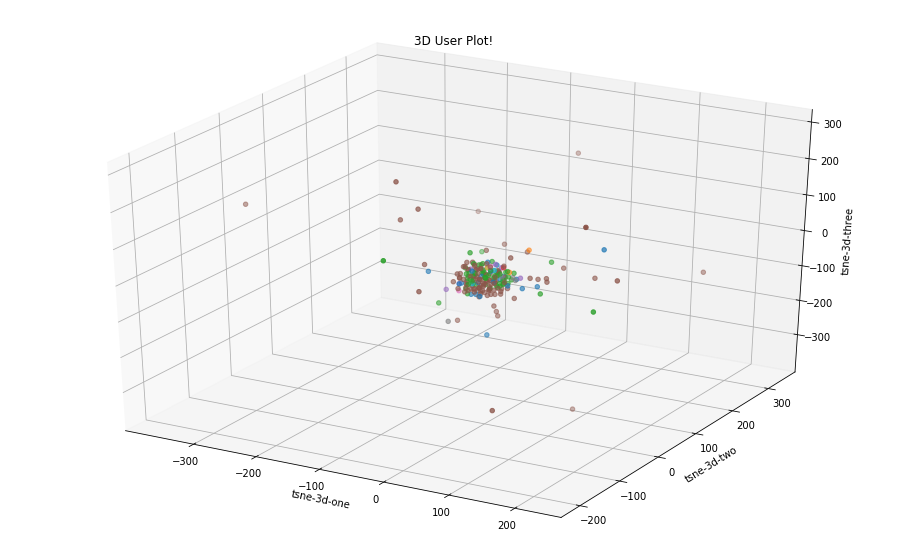

In [19]:
time_start = time.time()
tsne3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results_3d = tsne3d.fit_transform(df)

df['tsne-3d-one'] = tsne_results_3d[:,0]
df['tsne-3d-two'] = tsne_results_3d[:,1] 
df['tsne-3d-three'] = tsne_results_3d[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df['tsne-3d-one'], 
    ys=df['tsne-3d-two'], 
    zs=df['tsne-3d-three'], 
    c=clusters, 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')

plt.title("3D User Plot!")
# filename = "ITP_TSNE_Campers_Clustering_3D_{}.png".format(time_now)    
# plt.savefig(filename)
# plt.show()

## User's 5 Closest Euclidean Pairs:

In [20]:
df.reset_index().head()

,index,1,8,9,10,11,12,13,14,15,...,321,322,323,324,pca-one,pca-two,pca-three,tsne-3d-one,tsne-3d-two,tsne-3d-three
0,Abby Schmiedt,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0.863025,-1.204048,-0.935792,-1.253137,32.554478,1.167456
1,Ada Varriale (she/her),0,0,1,0,1,0,0,1,0,...,0,0,0,0,0.308597,-0.014107,-0.066404,11.340126,-16.448549,0.854130
2,Adeline Setiawan,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1.276104,1.529534,-1.458692,-0.102518,-28.661085,27.409271
3,Aki,0,0,1,0,0,0,0,0,0,...,0,0,0,0,-1.378247,-0.139152,0.812877,-4.045187,-4.429623,-30.081934
4,Alan Wong,0,1,0,1,1,0,0,1,0,...,0,0,0,0,2.628894,2.544156,-2.275225,12.366164,12.865513,20.017618


In [21]:
ex_user = "Matt Mitchell"
temp = df.reset_index().rename(columns={'index':'Name'})
row_number = temp[temp.Name==ex_user].index
# print(row_number)

In [22]:
closest_usr_indices = np.argsort(dist[row_number])[0,:10]
closest_usr_indices
closest_users = temp.loc[closest_usr_indices]['Name']
# closest_users

134                          Matt Mitchell
42                                 Coco Ma
155      Priyanka M\n            (she/her)
112     Kay Wasil\n            (they/them)
59                              Efrat Levy
44                         Daniel Shiffman
67                               Eric Kalb
169    Sam De Armas\n            (she/her)
41                              Clay Budin
209                 Xiaotian(Martin) Zhang
Name: Name, dtype: object

In [23]:
from sklearn.metrics import jaccard_score

In [25]:
cols = [col for col in df.columns if type(col)==int]
for user in closest_users:
    score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
#     print("{} Jaccard Similarity: {:%}".format(user, round(score,2)))

In [26]:
usr1_s_ids = [col for col in df.columns if df.loc[ex_user][col] == 1]
usr2_s_ids = [col for col in df.columns if df.loc[user][col] == 1]
# print(usr1_s_ids)
# print(usr2_s_ids)

In [37]:
df.head()

,1,8,9,10,11,12,13,14,15,16,...,321,322,323,324,pca-one,pca-two,pca-three,tsne-3d-one,tsne-3d-two,tsne-3d-three
Abby Schmiedt,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0.863025,-1.204048,-0.935792,-1.253137,32.554478,1.167456
Ada Varriale (she/her),0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0.308597,-0.014107,-0.066404,11.340126,-16.448549,0.854130
Adeline Setiawan,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.276104,1.529534,-1.458692,-0.102518,-28.661085,27.409271
Aki,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,-1.378247,-0.139152,0.812877,-4.045187,-4.429623,-30.081934
Alan Wong,0,1,0,1,1,0,0,1,0,0,...,0,0,0,0,2.628894,2.544156,-2.275225,12.366164,12.865513,20.017618


In [36]:
n_users = 10
similarities = []
for user in df.index:
    score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
    similarities.append((user, score))
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
print("Your {} most similar users are:\n".format(n_users))
print("\n".join(["{} similarity: {:.0%}".format(n, round(s,2)) for (n, s) in similarities[1:n_users]]))

Your 10 most similar users are:

Pinyao L similarity: 22%
Kaypree Hodges similarity: 19%
Phillip McFarlane similarity: 18%
Nathan Townes-Anderson (he/him) similarity: 18%
Ivanna Peña similarity: 17%
Shenghan Gao similarity: 16%
Ziwei Ji similarity: 16%
Iain Nash similarity: 16%
Daniel Tsadok
            (he/him) similarity: 15%


## How Many Sessions Have Folks Signed Up For?!

Sessions Per Persion Stats
Mean: 34.18 Median: 27.0


Text(0.5, 0, 'Number of Sessions Someone Signed Up For')

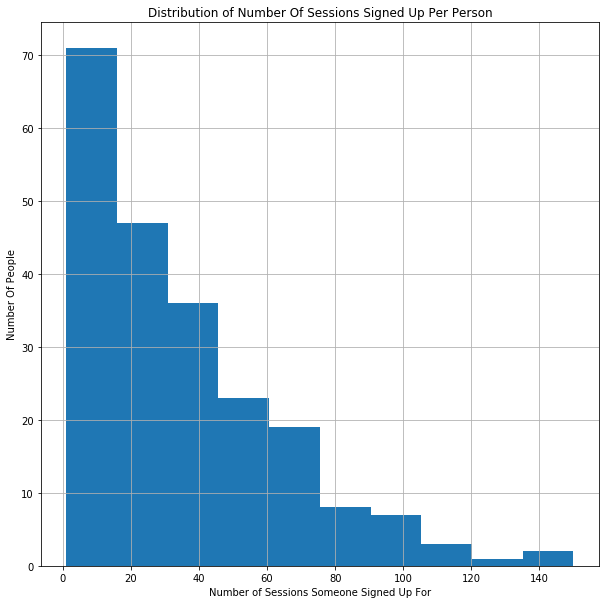

In [38]:
signups_pp = df[cols].sum(axis=1)
print("Sessions Per Persion Stats\nMean: {} Median: {}".format(round(np.mean(signups_pp),2),
                                                              round(np.median(signups_pp),2)
                                                              )
     )
signups_pp.hist(figsize=(10,10))
plt.title("Distribution of Number Of Sessions Signed Up Per Person")
plt.ylabel("Number Of People")
plt.xlabel("Number of Sessions Someone Signed Up For")

## Clustering With Keyword Tags

In [39]:
ucorp_df = pd.DataFrame(user_corpuses)
ucorp_df.columns = ['Name', 'Tags']
# print(ucorp_df.shape)
ucorp_df.head()

,Name,Tags
0,Abby Schmiedt,#drawing #illustration #code #graphics #3D #vi...
1,Ada Varriale (she/her),#shop #safety training #mandatory #p5.js #crea...
2,Adeline Setiawan,#innovation #materials #fieldtrip #p5.js #crea...
3,Aki,#ai #vr #dall-e 2 #3d #hdri #equirectangular #...
4,Alan Wong,#shop #safety training #mandatory #collage #pa...


In [40]:
corpus = ucorp_df.Tags

In [41]:
import lda
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [42]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000,
                                stop_words='english');
tf = tf_vectorizer.fit_transform(corpus)

In [43]:
n_topics = 15
model = lda.LDA(n_topics=n_topics, n_iter=1500, random_state=1);
model.fit(tf);

topic_word = model.topic_word_  # model.components_ also works
vocab = tf_vectorizer.get_feature_names();

INFO:lda:n_documents: 217
INFO:lda:vocab_size: 510
INFO:lda:n_words: 34751
INFO:lda:n_topics: 15
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -321250
INFO:lda:<10> log likelihood: -243908
INFO:lda:<20> log likelihood: -229858
INFO:lda:<30> log likelihood: -225287
INFO:lda:<40> log likelihood: -221495
INFO:lda:<50> log likelihood: -218904
INFO:lda:<60> log likelihood: -217517
INFO:lda:<70> log likelihood: -217143
INFO:lda:<80> log likelihood: -216538
INFO:lda:<90> log likelihood: -215693
INFO:lda:<100> log likelihood: -215035
INFO:lda:<110> log likelihood: -214647
INFO:lda:<120> log likelihood: -214038
INFO:lda:<130> log likelihood: -214093
INFO:lda:<140> log likelihood: -213585
INFO:lda:<150> log likelihood: -213356
INFO:lda:<160> log likelihood: -213299
INFO:lda:<170> log likelihood: -213189
INFO:lda:<180> log likelihood: -213040
INFO:lda:<190> log likelihood: -212905
INFO:lda:<200> log likelihood: -212774
INFO:lda:<210> log likelihood: -212945
INFO:lda:<220> log likelihood: -21

In [44]:
from wordcloud import WordCloud
import math

Topic 0: social allcamp food communitytech networking art music decentralization smoltech
Topic 1: games storytelling diversity narrative writing creative roleplaying fiction interactive
Topic 2: 3d design blender ar art vr simulation animation storytelling
Topic 3: javascript js web code html webgl ai p5 creative
Topic 4: art artistic mindfulness authenticity vision creativity living insight focus
Topic 5: music sound audio art generative digital ai processing daw
Topic 6: midi arduino social music design physicalcomputing art allcamp motion
Topic 7: 3d illustrator art blender fabrication modeling diy networking unity
Topic 8: art sculpture paper crafts sustainableart ai diy bioart sustainability
Topic 9: drawing illustration 3d design industrial narrative business wearables open
Topic 10: js creative p5 code coding intro training shop ml5
Topic 11: design intro interface 3d itp basics habits process 101
Topic 12: design ar computing mr spatial interaction wearables electronics fabric

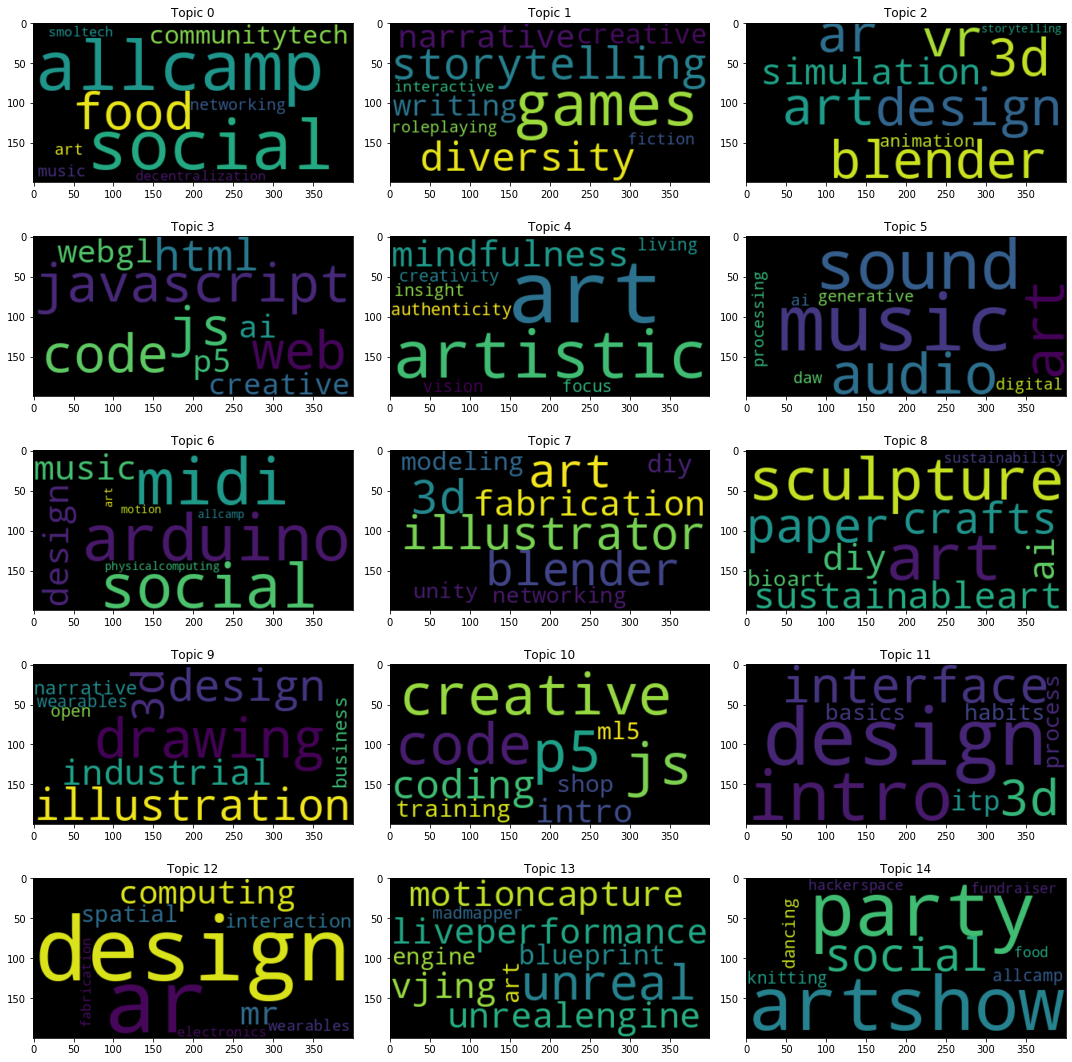

In [45]:
topic_word = model.topic_word_  # model.components_ also works
vocab = tf_vectorizer.get_feature_names();

n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    
ncols = 3
nrows = math.ceil(n_topics / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15)) #15 topics broken out 3 by 5
fig.tight_layout()
for i, topic_dist in enumerate(topic_word):
    topic_words = list(np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words):-1])
    topic_words = ' '.join(topic_words)
    row = i//ncols
    col = i%ncols
    ax = axes[row, col]
    wordcloud = WordCloud().generate(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Topic {}'.format(i))
plt.tight_layout()

In [46]:
cluster_probs = model.transform(tf)
clusters = [np.argmax(i) for i in clusters]
ucorp_df['LDA Tag Cluster'] = clusters

folder = "/Users/matthewmitchell/Documents/ITP_Camp/PeopleCluster/"
ucorp_df = pd.read_csv("{}LDA_Tag_Clusters_06-21-23_2101PM.csv".format(folder))
ucorp_df.head()

,Name,Tags,LDA Tag Cluster
0,Abby Schmiedt,#drawing #illustration #code #graphics #3D #vi...,10
1,Ada Varriale (she/her),#shop #safety training #mandatory #p5.js #crea...,10
2,Adeline Setiawan,#innovation #materials #fieldtrip #p5.js #crea...,10
3,Aki,#ai #vr #dall-e 2 #3d #hdri #equirectangular #...,2
4,Alan Wong,#shop #safety training #mandatory #collage #pa...,12


In [47]:
import ipywidgets as widgets

In [65]:
from fuzzywuzzy import fuzz, process

I'm not sure what you meant.

These are the top matches:
Winnie Yoe
Winston Williams
Adeline Setiawan
Alan Wong
Anita Chacinska
Anna Lin
Armanda Lewis
Binyan Xu
Caren Wenqing Ye
Carine Nimry


In [ ]:
"winston" 

In [ ]:
ucorp_df[ucord_df=='Name']

In [88]:
input_name = widgets.Text(value='Your Name!')
n_users = widgets.IntSlider(10, 1,30)

def process_ex_user(ex_user):
    if ex_user == "Your Name!" or ex_user.strip()=="":
        return None
    elif ex_user in df.index:
        return ex_user
    else:
        matches = process.extract(ex_user, df.index, limit=10)
        if len([m for m in matches if m[1]>=85])==1:
            print("I think you meant: {}".format(matches[0][0]))
            return matches[0][0]
        else:
            print("I'm not sure what you meant.\n")
            print("These are the top matches:")
            print("\n".join([m[0] for m in matches]))
            return None
def similar_users(input_name, n_users):
    ex_user = process_ex_user(input_name)
    if ex_user:
        similarities = []
        for user in df.index:
            score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
            similarities.append((user, score))
        similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
        print("Your {} most similar users based on class signups are:\n".format(n_users))
        print("\n".join(["{} similarity: {:.0%}".format(n, round(s,2)) for (n, s) in similarities[1:n_users]]))
        
out = widgets.interactive_output(similar_users, {'input_name':input_name, 'n_users':n_users})

button = widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

widgets.VBox([widgets.VBox([input_name, n_users]), out])
# widgets.HBox([widgets.HBox[ex_user], cluster])

In [84]:
input_name = widgets.Text(value='Your Name!')
n_users = widgets.IntSlider(10, 1,30)

def process_ex_user(ex_user):
    if ex_user == "Your Name!" or ex_user.strip()=="":
        return None
    elif ex_user in df.index:
        return ex_user
    else:
        matches = process.extract(ex_user, df.index, limit=10)
        if len([m for m in matches if m[1]>=85])==1:
            print("I think you meant: {}".format(matches[0][0]))
            return matches[0][0]
        else:
            print("I'm not sure what you meant.\n")
            print("These are the top matches:")
            print("\n".join([m[0] for m in matches]))
            return None

def similar_users(input_name, n_users):
    #ex_user = process_ex_user(input_name)
    if (input_name == "Your Name!") or (input_name == ""):
        pass
    elif input_name in df.index:
        ex_user = input_name
        similarities = []
        for user in df.index:
            score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
            similarities.append((user, score))
        similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
        print("Your {} most similar users based on class signups are:\n".format(n_users))
        print("\n".join(["{} similarity: {:.0%}".format(n, round(s,2)) for (n, s) in similarities[1:n_users]]))
    else:
        matches = process.extract(input_name, df.index, limit=10)
        if len([m for m in matches if m[1]>=85])==1:
            print("I think you meant: {}".format(matches[0][0]))
            similarities = []
            ex_user = matches[0][0]
            for user in df.index:
                score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
                similarities.append((user, score))
            similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
            print("Your {} most similar users based on class signups are:\n".format(n_users))
            print("\n".join(["{} similarity: {:.0%}".format(n, round(s,2)) for (n, s) in similarities[1:n_users]]))
        else:
            print("I'm not sure what you meant.\n")
            print("Did you mean:")
            print("\n".join([m[0] for m in matches]))
            return None
        
    
        
out = widgets.interactive_output(similar_users, {'input_name':input_name, 'n_users':n_users})

button = widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

widgets.VBox([widgets.VBox([input_name, n_users]), out])
# widgets.HBox([widgets.HBox[ex_user], cluster])

